## Step 6: Training on the merged dataset

### 6.1. Importing the Require Libraries


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
import lightgbm as lgb

### 6.2. Importing the dataset


In [3]:
csvFilePath = 'data/stocks/GoogleWithSentiment.csv'
df = pd.read_csv(csvFilePath)

### 6.3. Preproccessing the dataset for LIGHTGBM


In [4]:
features = df.drop(['Date', 'Close'], axis=1).values
target = df['Close'].values

# Scaling features
scalerFeatures = MinMaxScaler(feature_range=(0, 1))
scalerTarget = MinMaxScaler(feature_range=(0, 1))
featuresScaled = scalerFeatures.fit_transform(features)
targetScaled = scalerTarget.fit_transform(target.reshape(-1, 1)).ravel()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(featuresScaled, targetScaled, test_size=0.2, random_state=42)

# Convert data into LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

### 6.4. Building the LIGHTGBM model


In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

num_round = 1000
bst = lgb.train(params,
                train_data,
                num_round,
                valid_sets=[train_data, test_data],
                callbacks=[lgb.early_stopping(stopping_rounds=10),  # Early stopping callback
                           lgb.log_evaluation(10)]) # Log evaluation every 10 rounds

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1941, number of used features: 4
[LightGBM] [Info] Start training from score 0.329609
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.148006	valid_1's rmse: 0.147294
[20]	training's rmse: 0.0887468	valid_1's rmse: 0.0884626
[30]	training's rmse: 0.0532873	valid_1's rmse: 0.0533129
[40]	training's rmse: 0.0321168	valid_1's rmse: 0.0324208
[50]	training's rmse: 0.0195504	valid_1's rmse: 0.0201291
[60]	training's rmse: 0.012203	valid_1's rmse: 0.0130846
[70]	training's rmse: 0.00804821	valid_1's rmse: 0.00927531
[80]	training's rmse: 0.00584548	valid_1's rmse: 0.00738299
[90]	training's rmse: 0.00477539	valid_1's rmse: 0.00651978
[100]	training's rmse: 0.00428183	valid_1's rmse: 0.00617021
[110]	trainin

### 6.5. Testing the model


#### 6.5.1. Running prediction over the training set and testing set


In [16]:
# Predictions
trainPredict = bst.predict(X_train, num_iteration=bst.best_iteration)
testPredict = bst.predict(X_test, num_iteration=bst.best_iteration)

# Inverse transform predictions
trainPredictInv = scalerTarget.inverse_transform(trainPredict.reshape(-1, 1)).ravel()
trainYInv = scalerTarget.inverse_transform(y_train.reshape(-1, 1)).ravel()
testPredictInv = scalerTarget.inverse_transform(testPredict.reshape(-1, 1)).ravel()
testYInv = scalerTarget.inverse_transform(y_test.reshape(-1, 1)).ravel()

#### 6.5.2. Calculating the score and accuracy of the model


In [21]:
train_rmse = np.sqrt(mean_squared_error(trainYInv, trainPredictInv))
train_mae = mean_absolute_error(trainYInv, trainPredictInv)
train_r2 = r2_score(trainYInv, trainPredictInv)
train_accuracy = 100 - (train_rmse / np.mean(trainYInv) * 100)

test_rmse = np.sqrt(mean_squared_error(testYInv, testPredictInv))
test_mae = mean_absolute_error(testYInv, testPredictInv)
test_r2 = r2_score(testYInv, testPredictInv)
test_accuracy = 100 - (test_rmse / np.mean(testYInv) * 100)

metrics_data = {
    'Metric': ['RMSE', 'MAE', 'R²', 'Accuracy'],
    'Training Set': [train_rmse, train_mae, train_r2, train_accuracy],
    'Testing Set': [test_rmse, test_mae, test_r2, test_accuracy]
}

metrics_df = pd.DataFrame(metrics_data)

print(metrics_df)

     Metric  Training Set  Testing Set
0      RMSE      0.503775     0.935834
1       MAE      0.320058     0.564697
2        R²      0.999850     0.999475
3  Accuracy     99.367720    98.811843


#### 6.5.3. Visualizing the data

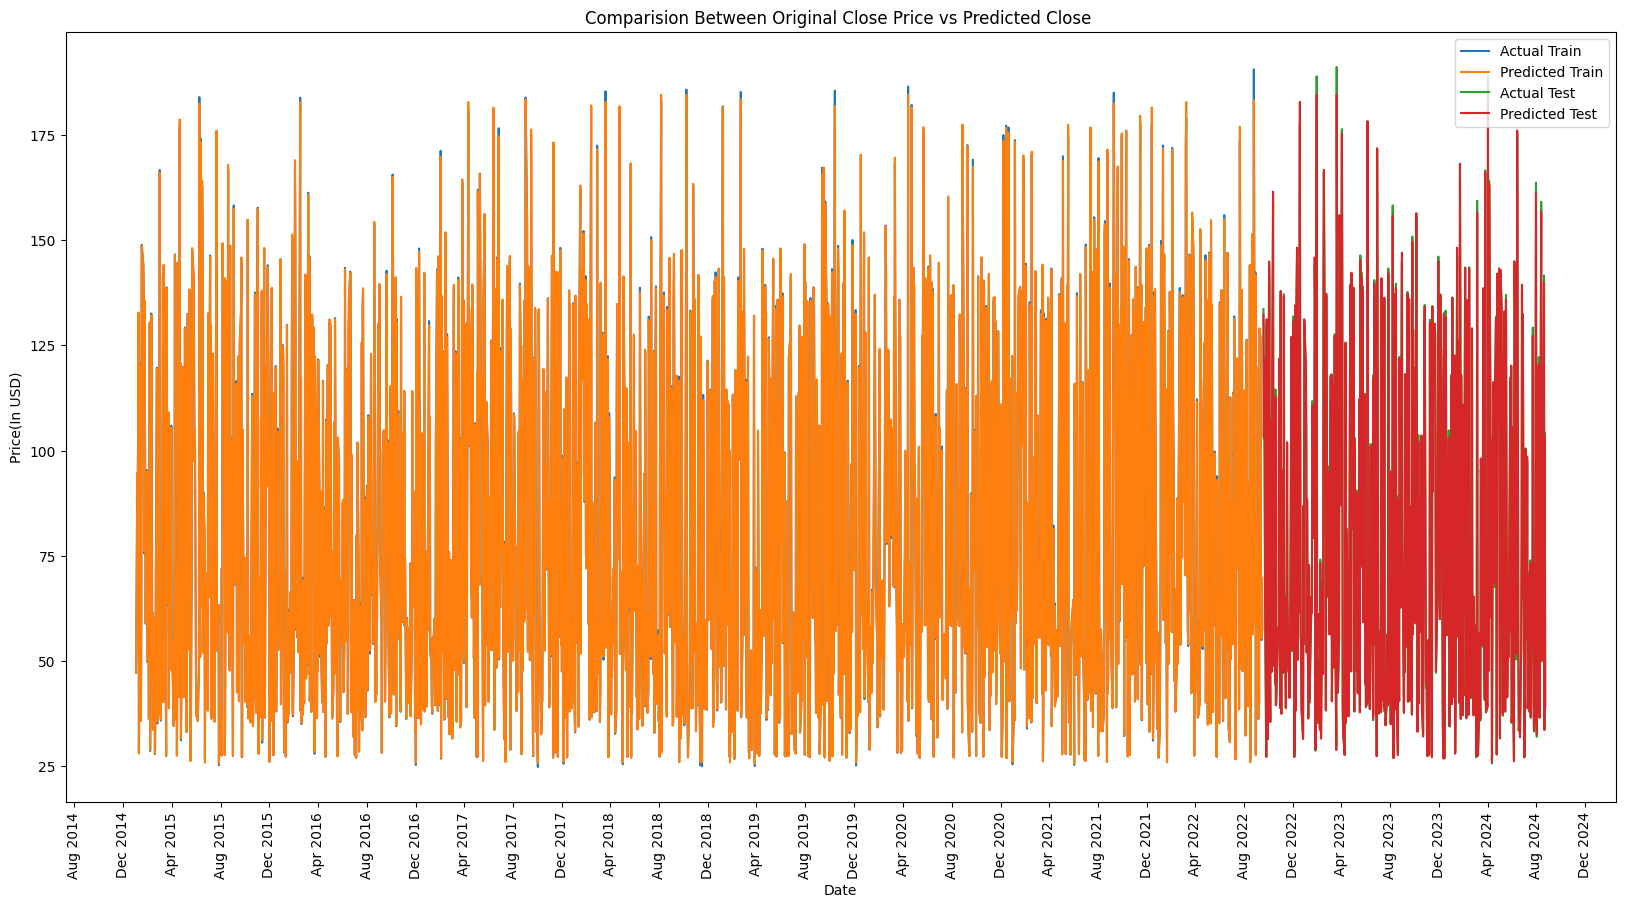

In [24]:
dates = pd.to_datetime(df['Date']).values
sampleInterval = 60
sampledDates = dates[::sampleInterval]

plt.figure(figsize=(20, 10))


plt.plot(dates[:len(trainYInv)], trainYInv, label='Actual Train')
plt.plot(dates[:len(trainPredictInv)], trainPredictInv, label='Predicted Train')
plt.plot(dates[len(trainYInv):len(trainYInv) + len(testYInv)], testYInv, label='Actual Test')
plt.plot(dates[len(trainPredictInv):len(trainPredictInv) + len(testPredictInv)], testPredictInv, label='Predicted Test')
plt.title("Comparision Between Original Close Price vs Predicted Close ")

plt.xlabel("Date")
plt.ylabel("Price(In USD)") 
plt.xticks(rotation=90)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.legend()
plt.show()